/var/folders/nf/0f78fmr95hz6c9cwnjjzzdlr0000gp/T/ipykernel_66963/1771051098.py:93: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  end_date = datetime.utcnow().date() + timedelta(days=1)  # inclusive



Sharpe-ranked comparison:
                    Sharpe   CAGR  MaxDD    Vol  Sortino
A_RP+MA_fixed+VT10   1.075  0.086 -0.089  0.081    1.368
Benchmark (SPY)      0.941  0.156 -0.245  0.172    1.295


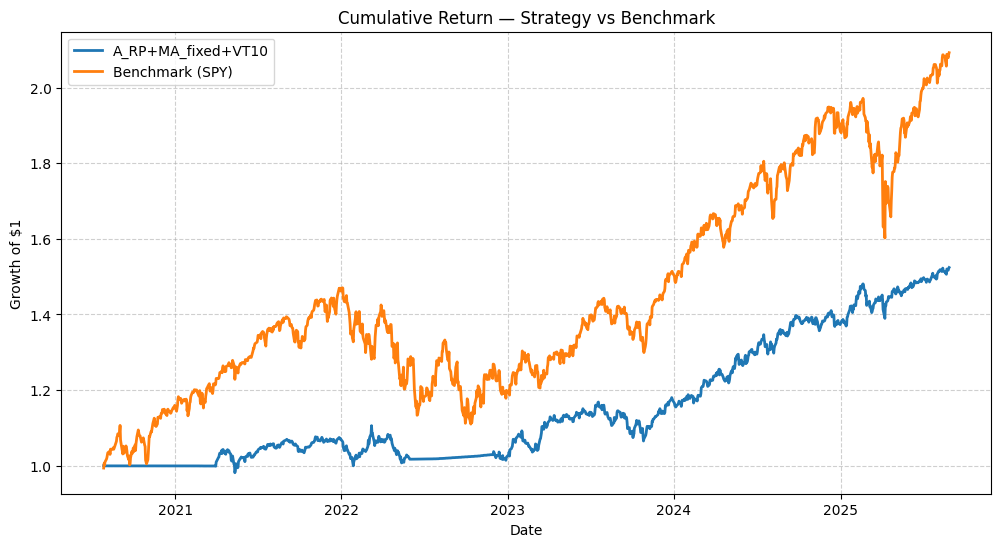

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dotenv import find_dotenv, load_dotenv
import alpaca_trade_api as tradeapi
from alpaca_trade_api.rest import REST, TimeFrame, APIError

load_dotenv(find_dotenv())

# =========================
# Settings
# =========================
START = "2001-01-01"
SLEEVES = ["QQQ", "BND", "GLD"]   # risky sleeves
CASH = "BIL"                      # defensive sleeve
REB = "W"                         # monthly rebalance
COST_BPS = 5                      # one-way trading cost

# Fixed MA windows (A strategy uses 150/150/150)
MA_FIXED = {"QQQ":150, "BND":150, "GLD":150}

# Risk-parity & smoothing
VOL_LKBK = 60                     # lookback for sleeve vol (inverse-vol weights)
EMA_ALPHA = 0.40                  # EMA smoothing for sleeve weights (None to disable)

# Portfolio vol targeting (VT10)
VT_TARGET = 0.10                  # annualized target vol (set None to disable)
VT_LKBK   = 60
GROSS_CAP = 1.25                  # cap on scaling

# ---- Benchmark ETF ----
BENCH_TKR = "SPY"                 # e.g., "AOR" (~60/40), or "SPY" for pure equity

# =========================
# Alpaca data helpers
# =========================
def _bars_to_daily_close_series(bars) -> pd.Series:
    """
    Convert Alpaca bars (bars.df or iterable) to a DATE-indexed Series of closes.
    If multiple entries per calendar day exist, keeps the LAST close of that day.
    """
    if bars is None:
        return pd.Series(dtype=float)

    # Prefer bars.df when present
    if hasattr(bars, "df"):
        df = bars.df.copy()
        if df is None or df.empty or "close" not in df.columns:
            return pd.Series(dtype=float)
        # Ensure datetime index
        if not isinstance(df.index, pd.DatetimeIndex):
            if "timestamp" in df.columns:
                df.index = pd.to_datetime(df["timestamp"], utc=True, errors="coerce")
            elif "t" in df.columns:
                df.index = pd.to_datetime(df["t"], utc=True, errors="coerce")
            else:
                return pd.Series(dtype=float)
        dates = df.index.tz_convert(None).normalize()
        ser = pd.Series(pd.to_numeric(df["close"], errors="coerce").values, index=dates)
        return ser.groupby(level=0).last().dropna().sort_index()

    # Fallback: try to coerce generic iterables (Bar objects or dicts)
    rows = []
    try:
        for b in bars:
            t = getattr(b, "t", None) or getattr(b, "timestamp", None)
            c = getattr(b, "c", None) or getattr(b, "close", None)
            if t is None and isinstance(b, dict):
                t = b.get("t", b.get("timestamp"))
            if c is None and isinstance(b, dict):
                c = b.get("c", b.get("close"))
            if t is None or c is None:
                continue
            rows.append((t, c))
    except TypeError:
        return pd.Series(dtype=float)

    if not rows:
        return pd.Series(dtype=float)
    df = pd.DataFrame(rows, columns=["t", "c"])
    ts = pd.to_datetime(df["t"], utc=True, errors="coerce").tz_convert(None)
    ser = pd.Series(pd.to_numeric(df["c"], errors="coerce").values, index=ts.normalize())
    return ser.groupby(level=0).last().dropna().sort_index()


def _download_closes_alpaca(api: REST, tickers, start: str) -> pd.DataFrame:
    """
    Fetch daily closes for all tickers from 'start' through today (inclusive),
    using Alpaca's IEX feed and adjustment='all'.
    """
    end_date = datetime.utcnow().date() + timedelta(days=1)  # inclusive
    start_date = pd.to_datetime(start).date()

    series = {}
    missing = []
    for t in sorted(set(tickers)):
        try:
            bars = api.get_bars(
                t,
                TimeFrame.Day,
                start_date.strftime("%Y-%m-%d"),
                end_date.strftime("%Y-%m-%d"),
                adjustment="all",
                feed="iex",
            )
        except APIError as e:
            print(f"[WARN] APIError for {t}: {e}")
            bars = None

        ser = _bars_to_daily_close_series(bars)
        if ser.empty:
            missing.append(t)
        else:
            series[t] = ser

    if not series:
        raise RuntimeError(
            f"No bars returned. Check feed/permissions. Tried: {tickers} | start={start_date} end={end_date}"
        )

    df = pd.concat(series, axis=1).dropna(how="all")
    df.index.name = "Date"
    if missing:
        print(f"[INFO] No data for: {missing}. Proceeding with available: {list(series.keys())}")
    return df

# =========================
# Backtest data
# =========================
api = tradeapi.REST(
    os.getenv("ALPACA_KEY_ID"),
    os.getenv("ALPACA_SECRET_KEY"),
    base_url=os.getenv("ALPACA_BASE_URL"),
) 

tickers = sorted(set(SLEEVES + [CASH, BENCH_TKR]))
px_all = _download_closes_alpaca(api, tickers, START)     



px_all = px_all.dropna(axis=1, how="all")

# Ensure sleeves + cash exist
present = [t for t in SLEEVES + [CASH] if t in px_all.columns]
px = px_all[present].dropna(how="any")
rets = px.pct_change().dropna()

# Benchmark (align to strategy timeline later)
if BENCH_TKR in px_all.columns:
    bench_px = px_all[BENCH_TKR].dropna()
    bench_rets = bench_px.pct_change().dropna()
else:
    bench_rets = None

# Month-end (or choose weekly if REB == "W")
if REB.upper().startswith("M"):
    rbd = rets.groupby([rets.index.year, rets.index.month]).tail(1).index
elif REB.upper().startswith("W"):
    # last trading day of each ISO week in the data
    df_tmp = pd.Series(1, index=rets.index)
    rbd = df_tmp.groupby([rets.index.isocalendar().year, rets.index.isocalendar().week]).tail(1).index
else:
    # default: rebalance daily (not typical, but allowed)
    rbd = rets.index

# =========================
# Helpers
# =========================
def kpi(ser: pd.Series):
    s = ser.dropna()
    if s.empty:
        return dict(CAGR=np.nan, Sharpe=np.nan, Vol=np.nan, Sortino=np.nan, MaxDD=np.nan)
    cum = (1 + s).cumprod()
    yrs = (s.index[-1] - s.index[0]).days / 365.25
    cagr = cum.iloc[-1] ** (1 / yrs) - 1 if yrs > 0 else np.nan
    vol = s.std() * np.sqrt(252)
    sharpe = (s.mean() * 252) / vol if vol > 0 else np.nan
    mdd = (cum / cum.cummax() - 1).min()
    dvol = s[s < 0].std() * np.sqrt(252) if (s < 0).sum() > 1 else np.nan
    sortino = (s.mean() * 252) / dvol if (isinstance(dvol, float) and dvol > 0) else np.nan
    return dict(CAGR=cagr, Sharpe=sharpe, Vol=vol, Sortino=sortino, MaxDD=mdd)

def ma_signal(series: pd.Series, win: int) -> pd.Series:
    ma = series.rolling(win).mean()
    return (series > ma).astype(int)

def invvol_weights(names, asof, lookback=VOL_LKBK):
    w = pd.Series(0.0, index=px.columns)
    if not names:
        return w
    sub = rets[names].loc[:asof].tail(lookback)
    vol = sub.std()
    inv = 1 / vol.replace(0, np.nan)
    inv = inv.fillna(0)
    if inv.sum() == 0:
        w.loc[names] = 1 / len(names)
    else:
        w.loc[names] = inv / inv.sum()
    return w

def portfolio_returns(W: pd.DataFrame, vt_target: float | None = VT_TARGET):
    dW = W.reindex(rets.index).ffill().fillna(0.0)
    gross = (dW.shift(1) * rets).sum(axis=1)

    # trading costs on rebalance days
    Wprev = W.shift(1).fillna(0.0)
    tnov = (W - Wprev).abs().sum(axis=1)
    tcost = tnov * (COST_BPS / 10000.0)
    cost = pd.Series(0.0, index=gross.index)
    reb_days = cost.index.intersection(W.index)
    cost.loc[reb_days] = tcost.reindex(reb_days).fillna(0.0)

    pr = gross - cost

    # vol targeting (simple scaling; capped)
    if vt_target is not None:
        roll = pr.rolling(VT_LKBK).std() * np.sqrt(252)
        scale = (vt_target / roll.replace(0, np.nan)).clip(upper=GROSS_CAP).fillna(1.0)
        pr = pr * scale
    return pr

# =========================
# Build A_RP+MA_fixed+VT10 weights
# =========================
def build_weights_no_macro():
    sig = {t: ma_signal(px[t], MA_FIXED.get(t, 150)).reindex(px.index).fillna(0) for t in SLEEVES}
    W = pd.DataFrame(index=rbd, columns=px.columns, data=0.0)
    ema_prev = None

    for d in rbd:
        # sleeves ON by MA + enough history
        on = [t for t in SLEEVES if int(sig[t].loc[:d].iloc[-1]) == 1 and len(rets[t].loc[:d]) >= VOL_LKBK + 5]
        if not on:
            row = pd.Series(0.0, index=px.columns); row[CASH] = 1.0
            W.loc[d] = row; ema_prev = row; continue

        # inverse-vol risk parity
        w_rp = invvol_weights(on, d, VOL_LKBK)
        w_rp = (w_rp[w_rp > 0] / w_rp[w_rp > 0].sum()) if w_rp.sum() > 0 else pd.Series(1 / len(on), index=on)
        row = pd.Series(0.0, index=px.columns); row[w_rp.index] = w_rp.values

        # EMA smoothing (on sleeves only)
        if EMA_ALPHA is not None and ema_prev is not None and 0 < EMA_ALPHA < 1:
            sm = ema_prev.copy()
            for t in SLEEVES:
                prev = float(ema_prev.get(t, 0.0))
                sm[t] = (1 - EMA_ALPHA) * prev + EMA_ALPHA * float(row.get(t, 0.0))
            ss = sm[SLEEVES].sum()
            if ss > 0:
                sm[SLEEVES] = sm[SLEEVES] / ss
            row = sm

        # normalize
        tot = row.sum()
        if tot > 0: row = row / tot
        else: row[CASH] = 1.0

        W.loc[d] = row
        ema_prev = row

    return W

# =========================
# Run strategy & benchmark
# =========================
W_A = build_weights_no_macro()
ret_A = portfolio_returns(W_A, vt_target=VT_TARGET)

# Align benchmark to strategy return timeline
if bench_rets is not None:
    bench_aligned = bench_rets.reindex(ret_A.index).dropna()
    ret_A_aligned = ret_A.reindex(bench_aligned.index).dropna()
else:
    bench_aligned = None
    ret_A_aligned = ret_A.copy()

# =========================
# Report metrics
# =========================
rows = {"A_RP+MA_fixed+VT10": kpi(ret_A)}
if bench_aligned is not None:
    rows[f"Benchmark ({BENCH_TKR})"] = kpi(bench_aligned)

res = (
    pd.DataFrame(rows)
    .T[["Sharpe","CAGR","MaxDD","Vol","Sortino"]]
    .sort_values("Sharpe", ascending=False)
)

print("\nSharpe-ranked comparison:")
print(res.round(3))

# =========================
# Plot cumulative returns
# =========================
plt.figure(figsize=(12,6))
cum_A = (1 + ret_A_aligned).cumprod()
plt.plot(cum_A.index, cum_A, linewidth=2, label="A_RP+MA_fixed+VT10")

if bench_aligned is not None:
    cum_B = (1 + bench_aligned).cumprod()
    plt.plot(cum_B.index, cum_B, linewidth=2, label=f"Benchmark ({BENCH_TKR})")

plt.title("Cumulative Return — Strategy vs Benchmark")
plt.xlabel("Date"); plt.ylabel("Growth of $1")
plt.grid(True, linestyle="--", alpha=0.6); plt.legend()
plt.show()
